In [117]:
'''
ASTP-720, Fall 2020
Final Project
Zach Diermyer
'''

import numpy as np
import matplotlib.pyplot as plt

In [104]:
def AngMom(r, m, v):
    '''
    Calculates angular momentum of a star particle
    Inputs:
        r - Radial distance star particle is from center in meters
        m - Mass of star particle in kg
        v - Tangential velocity of star particle in m/s
    Returns:
        r*m*v - Product of inputs is particle angular momentum
    '''
    return(r*m*v)

In [105]:
def StarAngMom(omega, R, M):
    '''
    Calculates angular momentum of a star
    Inputs:
        omega - Angular velocity of star in rad/s
        R - Radius of star in meters
        M - Mass of star in kg
    Returns:
        L - Total star angular momentum
    '''
    I = (2/5)*M*(R**2)
    L = I*omega
    return(L)

In [106]:
def RotVel(L, M, R):
    '''
    Calculates the rotational velocity of star
    Inputs:
        L - Angular momentum of star, kgs units
        M - Mass of star in kg
        R - Radius of star in meters
    Returns:
        v - Star rotational velocity in m/s
    '''
    omega = L/((2/5)*M*(R**2))
    v = omega*R
    return(v)

In [107]:
def CalcPotent(M, r):
    '''
    Calculates the gravitational potential at any point due to a star
    Inputs:
        M - Mass of star in kg
        r - Radial distance from star in meters
    '''
    G = 6.67*10**-11
    phi = G*M/(r**2)
    return(phi)

In [108]:
def MakeCluster(M, R, v, resolution):
    '''
    Creates a 2D array containing 'star particles' at various radial segments of the star
    Inputs:
        M - Mass of star in solar masses
        R - Radius of star in solar radii
        v - Velocity of star in km/s
        resolution - Mass of each individual star particle
    Returns:
        clust - Star cluster array, each element is an array containing the coordinates of radial distance from center
                of star and angular momentum of each star particle in that shell.
    '''
    Nparticles = M/resolution
    Nshells = 1   #Start layering shells outside core
    while Nparticles > 0:
        Nshells += 1
        Nparticles -= 2**Nshells   #Each shell has 2^n star particles (except the core which has 1 for convenience)
    dr = R/Nshells
    Mpart = resolution   #Mass of each star particle
    core = [0, 0]
    clust = [core]
    Mclust = resolution   #Total cluster mass strting from core
    n = 2   #Shell stepping variable
    omega = (v*10**3)/(R*6.96*10**8)
    while Mclust < M:
        r = dr*n
        rmeter = r*6.96*10**8
        vr = omega*rmeter
        L = AngMom(rmeter, resolution, vr)
        shellmass = resolution * (2**n)
        if shellmass+Mclust <= M:   #Full shell condition
            shell = [[r, L]] * (2**n)
            clust.append(shell)
            Mclust += shellmass
        else:
            shell = []
            while Mclust < M:      #Outer shell fill in remaining particles
                shell.append([r, L])
                Mclust += resolution
            clust.append(shell)
        n += 1
    return(clust)

In [109]:
def UpdateMember(star1, M1, star2, M2, separation):
    '''
    Finds if outer shells of AGB star are removed by the white dwarf companion
    Inputs:
        star1 - 2D array of AGB star particles cluster
        M1 - AGB star mass in solar masses
        star2 - 2D array of WD star particles cluster
        M2 - WD star mass in solar masses
        separation - Orbital separation of the stars in meters
    Returns:
        transfer - Array of AGB star paticles transferred
    '''
    transfer = []
    M1kgs = M1 * 2*10**30   #AGB star mass in kg
    M2kgs = M2 * 2*10**30   #White dwarf star mass in kg
    for i in range(1, len(star1)):
        R1 = star1[i][0][0] * 6.96*10**8
        R2 = star2[-1][0][0] * 6.96*10**8
        pot1 = CalcPotent(M1kgs, R1)
        pot2 = CalcPotent(M2kgs, separation-R2)
        if pot2 > pot1:   #AGB star fills it's Roche Lobe
            transfer.append(star1[i])
        else:
            pass
    return(transfer)

In [110]:
def MassExchange(transfer, resolution):
    '''
    Sums the amount of mass transferred from AGB star to WD star
    Inputs:
        transfer - 2D array of particles taken from AGB star
        resolution - Mass of each individual particle
    Returns:
        tot - Total mass transferred
    '''
    tot = 0
    for i in range(len(transfer)):
        tot += len(transfer[i])*resolution
    return(tot)

In [111]:
def NewVel(v0, r0, m0, transfer, WD):
    '''
    Finds the change in angular momentum then uses that to find the new rotational velocity of the star
    Inputs:
        v0 - Initial rotational velocity of star in km/s
        r0 - Initial radius of star in solar radii
        m0 - Initial mass of star in solar masses
        transfer - 2D array of trasnferred star particles
        WD - Boolean, True if the input star parameters are of the white dwarf star
    Returns:
        v/10**3 - New velocity of star converted to km/s
    '''
    tot = 0
    for i in range(len(transfer)):
        for j in range(len(transfer[i])):
            tot += transfer[i][j][1]
    rmeter = r0 * 6.96*10**8
    mkgs = m0 * 2*10**30
    omega = (v0*10**3)/rmeter
    L = StarAngMom(omega, rmeter, mkgs)   #Find angular momentum of entire star
    if WD == True:
        newL = L + (tot*10**28)   #White dwarf gains angular momentum
    else:
        newL = L - (tot*10**30)
    v = RotVel(newL, mkgs, rmeter)
    return(v/(10**3))

In [133]:
def StarPlot(clust, color, transfer):
    '''
    Plots an individual star or white dwarf and gained shells of AGB star
    Inputs:
        clust - Cluster of star particles array
        color - Star color
        transfer - Transferred shells of AGB star, input empty array for individual star plot
    Returns:
        nothing, creates plot
    '''
    r = [0]
    theta = []
    for i in range(1, len(clust)):
        for j in range(len(clust[i])):
            r.append(clust[i][j][0])
            theta.append(2 * np.pi * np.random.rand())
    if len(transfer) > 0:
        rt = []
        thetat = []
        for i in range(len(transfer)):
            for j in range(len(transfer[i])):
                rt.append(transfer[i][j][0])
                thetat.append(2 * np.pi * np.random.rand())
        theta.append(2 * np.pi * np.random.rand())
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='polar')
        c = ax.scatter(theta, r, c =color, cmap='hsv', alpha=0.75)
        d = ax.scatter(thetat, rt, c ='r', cmap='hsv', alpha=0.75)
    else:
        theta.append(2 * np.pi * np.random.rand())
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='polar')
        c = ax.scatter(theta, r, c = color, cmap='hsv', alpha=0.75)

Mass of red giant star (solar masses): 22
Mass of white dwarf star (solar masses): 1
Initial rotational velocity of AGB star (km/s): 34
Initial rotational velocity of WD star (km/s): 45
Binary separation (AU): 0.01
Mass transferred from AGB star to white dwarf: 1.55 Solar Masses
AGB star rotational velocity after mass transfer: 31.00568181818182 (km/s)
WD star rotational velocity after mass transfer: 48.83620278501402 (km/s)


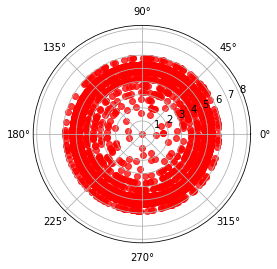

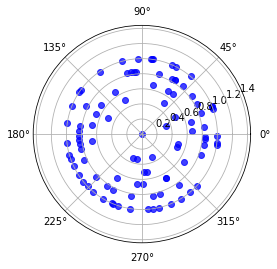

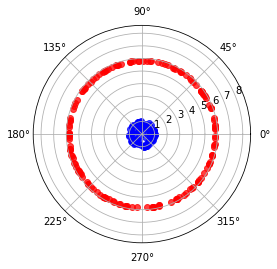

In [134]:
def main():
    while True:
        m1 = float(input("Mass of red giant star (solar masses): "))
        if 0.1 <= m1 <= 100:
            break
        else:
            print("Mass must be between 0.1 and 100 solar masses!")
    r1 = m1**0.57  #Approximate mass radius relation, solar units
    while True:
        m2 = float(input("Mass of white dwarf star (solar masses): "))
        if 0.4 <= m2 <= 1.44:
            break
        else:
            print("Mass must be between 0.4 and 1.44 solar masses!")
    r2 = m2**(-1/3)  #Non-relatavistic mass radius relation, solar units
    while True:
        v1 = float(input("Initial rotational velocity of AGB star (km/s): "))
        v2 = float(input("Initial rotational velocity of WD star (km/s): "))
        if 10 <= v1 <= 250 and 10 <= v2 <= 250:
            break
        else:
            print("Velocities must be between 10 and 250 km/s!")
    while True:
        sepAU = float(input("Binary separation (AU): "))
        if 0.0001 <= sepAU <= 100:
            break
        else:
            print("Separation must be between 0.0001 and 100 AU!")
    sepmeter = sepAU * 1.5*10**11
    resolution = 0.01  #Mass of particles that make up star in solar masses
    AGBclust = MakeCluster(M = m1, R = r1, resolution = resolution, v = v1)
    WDclust = MakeCluster(M = m2, R = r2, resolution = resolution, v = v2)
    transfer = UpdateMember(AGBclust, m1, WDclust, m2, sepmeter)
    massmove = MassExchange(transfer, resolution)
    print("Mass transferred from AGB star to white dwarf: " + str(massmove) + " Solar Masses" )
    if massmove > 0:
        print("AGB star rotational velocity after mass transfer: " + str(NewVel(v1, r1, m1, transfer, False)) + " (km/s)")
        print("WD star rotational velocity after mass transfer: " + str(NewVel(v2, r2, m2, transfer, True)) + " (km/s)")
    else:
        print("No change in mass")
    StarPlot(AGBclust, 'r', [])
    StarPlot(WDclust, 'b', [])
    StarPlot(WDclust, 'b', transfer)
main()